In [351]:
import numpy as np
import scipy.io as sio
import scipy
import matplotlib.pyplot as plt
import math

IMG_SET_ID = 7
path = ""
dist_name = path + "distances_" + str(IMG_SET_ID) + ".mat"
PSF_name  = path + "GaussStd2Color_" + str(IMG_SET_ID) + ".mat"
PSF_NIR_name = path + "GaussStd2Nir_" + str(IMG_SET_ID) + ".mat"

mat_dist = sio.loadmat(dist_name)
mat_PSF = sio.loadmat(PSF_name)
mat_PSF_NIR = sio.loadmat(PSF_NIR_name)

distances = mat_dist['distancesCol']
PSF       = mat_PSF['GaussStd2Color']
PSF_NIR   = mat_PSF_NIR['GaussStd2Nir']

#PSF = np.hstack((PSF, np.transpose(PSF_NIR)))
PSF[:,3] = PSF_NIR

distances2 = np.squeeze(distances)
diff_dist = [x - distances2[i - 1] for i, x in enumerate(distances2) if i > 0]
print(distances2)
#b = np.zeros((50, 2))
#b[:,0] = diff_dist
#b[:,1] = range(len(diff_dist))
#print(b)

[1059 1109 1159 1209 1259 1309 1359 1409 1459 1509 1559 1609 1659 1709 1759
 1809 1859 1909 1959 2009 2059 2109 2159 2209 2259 2309 2359 2409]


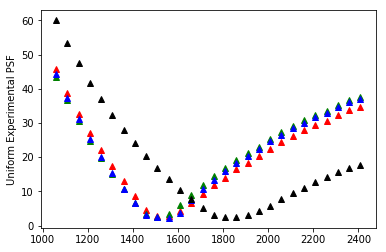

In [352]:
#plt.plot(distances, PSF[:,channelIdx], 'g^')
#plt.ylabel('Experimental PSF')
#plt.show()


INDICES_4 = np.array([-1, 0, 1, 2, 3, 4, 5, 6, 7, 9, 13, 17, 19, 20, 21, 22, 23, 24, 25, 27, 31, 35, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49])
INDICES_4 += 1


if IMG_SET_ID == 4:
    PSF_uniform = np.zeros((len(INDICES_4),4))
    distances_uniform = np.zeros((len(INDICES_4),1))
    idx_uniform = 0
    for idx in range(len(INDICES_4)):
        PSF_uniform[idx,:] = PSF[ INDICES_4[idx], : ]
        distances_uniform[idx] = distances[ INDICES_4[idx] ]

if IMG_SET_ID == 6:
    PSF_uniform = PSF
    distances_uniform = distances

if IMG_SET_ID == 7:
    PSF_uniform = PSF
    distances_uniform = distances
    

plt.plot(distances_uniform, PSF_uniform[:,0], 'r^')
plt.plot(distances_uniform, PSF_uniform[:,1], 'g^')
plt.plot(distances_uniform, PSF_uniform[:,2], 'b^')
plt.plot(distances_uniform, PSF_uniform[:,3], 'k^')
plt.ylabel('Uniform Experimental PSF')
plt.show()
            


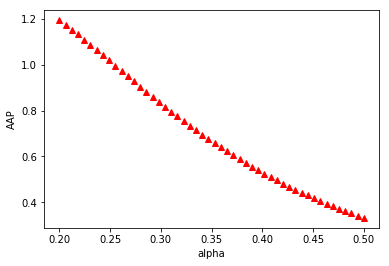

[0.20000000000000001, 1.1930309648392832]
[0.35306122448979593, 0.65789059828847485]
[0.5, 0.33245091634614021]


In [353]:
# Polynomial fitting:
x = np.squeeze(0.001*distances_uniform)
deg = 4
N = 3
polyParams = np.zeros((N,deg+1))
for channelIdx in range(N):
    polyParams[channelIdx, :] = np.polyfit(x, PSF_uniform[:, channelIdx], deg)

#print(polyParams)

# Finding x0
x0 = np.zeros(N)
for channelIdx in range(N):
    f = np.poly1d( polyParams[channelIdx, :] )
    result = scipy.optimize.minimize_scalar(f, bounds=(x[0], x[-1]), method='bounded')
    x0[channelIdx] = result.x

#print(x0)

# Computing c_ij & d_ij
c_ij = np.zeros((int(0.5*N*(N-1)),deg+1))
d = np.zeros((int(0.5*N*(N-1)),2*deg+1))
duo = 0 #corresponds to ij pairs in vectorized form
for i in range(N):
    for j in range(i+1,N):
        c_ij[duo, :] = polyParams[i, :] - polyParams[j, :]
        for k in range(2*deg+1):
            d[duo, k] = 0
            for u in range(deg+1):
                for v in range(deg+1):
                    if u+v == k:
                        d[duo, k] += c_ij[duo, u] * c_ij[duo, v]
        duo += 1
        

#print(c_ij)
#print(d)




# Compute the AAP for varying alpha
alphaLIST = np.linspace(0.2, 0.5, 50)
AAP = np.zeros(len(alphaLIST))
# B_ij  RG   RB   RN   GB   GN   BN
B_ij = [0.2, 0.3, 0.4, 0.2, 0.5, 0.6]
if N == 3:
    # B_ij  RG   RB   GB
    B_ij = [0.2, 0.3, 0.2]

for alphaIdx in range(len(alphaLIST)):
    # Computing delta_alpha bar
    alpha = alphaLIST[alphaIdx]
    delta = np.zeros(int(0.5*N*(N-1)))
    a_ij = np.zeros(int(0.5*N*(N-1)))
    b_ij = np.zeros(int(0.5*N*(N-1)))
    duo = 0 #corresponds to ij pairs in vectorized form
    for i in range(N):
        for j in range(i+1,N):
            a_ij[duo] = (1-alpha) * min( x0[i], x0[j] )
            b_ij[duo] = (1+alpha) * max( x0[i], x0[j] )

            for k in range(1, 2*deg+1+1):
                delta[duo] += d[duo, k-1] * (b_ij[duo]**k - a_ij[duo]**k) / k

            delta[duo] = delta[duo] / (b_ij[duo] - a_ij[duo])

            duo += 1


    for duo in range(int(0.5*N*(N-1))):
            AAP[alphaIdx] += B_ij[duo] * (b_ij[duo] - a_ij[duo]) / delta[duo]

    AAP[alphaIdx] = 100000 * AAP[alphaIdx] * 2 / (N*(N-1))
    #AAP[alphaIdx] = np.log( AAP[alphaIdx] )



plt.plot(alphaLIST, AAP, 'r^', label="y reconst")
plt.ylabel('AAP')
plt.xlabel('alpha')
plt.show()

print([alphaLIST[0], AAP[0]])
print([alphaLIST[25], AAP[25]])
print([alphaLIST[49], AAP[49]])


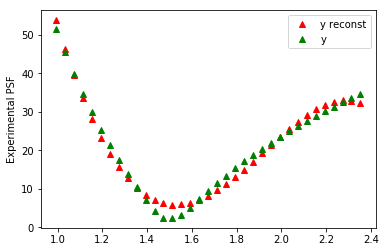

In [254]:

y_poly = sum(coef * x**exp for exp, coef in enumerate(reversed(polyParams[1, :])))
#for exp, coef in enumerate(reversed(polyParams)):
#    print(exp,coef)

plt.plot(x, y_poly, 'r^', label="y reconst")
plt.plot(x, y, 'g^', label="y")
plt.ylabel('Experimental PSF')
plt.legend()
plt.show()

[  1.18181103e+05   1.24817335e+00   1.24714040e+00  -2.10215812e-01]


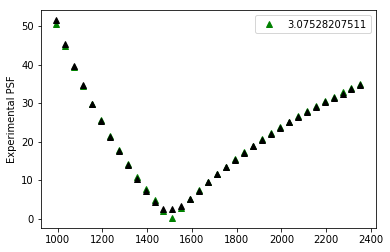

In [187]:
from scipy.optimize import curve_fit

def fit_PSF_func(x, L, d, f, c):
    return np.transpose(np.array(  (L * abs( 1 - d/f + d/x ) + c)  ))[0]

x = distances_uniform
y = PSF_uniform[:, channelIdx]

#params = curve_fit(fit_PSF_func, x, y, p0=(140989., 1.055, 1.054, 2.054))
#params = curve_fit(fit_PSF_func, x, y, bounds=((0,0,0,-np.inf),(np.inf, np.inf, np.inf, np.inf)), p0=(140989., 1.055, 1.054, 2.054))
params = curve_fit(fit_PSF_func, x, y, bounds=((0,0,0,-np.inf),(np.inf, np.inf, np.inf, np.inf)), p0=(70989., 1.055, 1.054, 2.054))

simpleLensParams = params[0]
PSF_fitted = fit_PSF_func(x, simpleLensParams[0], simpleLensParams[1], simpleLensParams[2], simpleLensParams[3])

#PARAMS_GREEN_SET4 = [1.30744663e+05   1.12823345e+00   1.12738942e+00  -2.10215811e-01]
print(simpleLensParams)



err_fit = np.linalg.norm(PSF_fitted - y)
plt.plot(x, PSF_fitted, 'g^', label=str(err_fit))
plt.plot(x, y, 'k^')
plt.ylabel('Experimental PSF')
plt.legend()
plt.show()



In [ ]:
from scipy.optimize import least_squares
from scipy.optimize import leastsq

def fit_PSF_loss(opt_vector, x, y):
    L, d, f = opt_vector
    #return L * abs( 1 - d/f + d/x )
    y_fit = (L * abs( 1 - d/f + d/x ))
    diff  = y_fit.reshape((-1,)) - y
    return diff

channelIdx = 4

x = distances
y = PSF[:, channelIdx]
x0 = np.array([1, 2, 3])
params = leastsq(fit_PSF_loss, x0=x0, args=(x,y), xtol=1e-15)
simpleLensParams = params[0]

#PSF_fitted = fit_PSF_func(distances, simpleLensParams[0], simpleLensParams[1], simpleLensParams[2])

plt.plot(distances, PSF_fitted, 'g^')
plt.ylabel('Experimental PSF')
plt.show()
